In [ ]:
! pip install pymc3 --upgrade

In [ ]:
import pymc3

In [ ]:
! pip install arviz

In [ ]:
from scipy import stats
from statsmodels.stats import proportion
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc3 as pm

### Example 1


In [ ]:
# Estimating population mean of observations generated from Poisson distribution
event_rate = 1000                             # true population mean
p_sample_size = 10
p_n_samples = 10000
poisson_samples = stats.poisson(event_rate).rvs(size=(p_n_samples,p_sample_size))        # Generate samples 

In [ ]:
# computing sample means
sample_avg = poisson_samples.mean(1)
sample_avg

array([ 998. ,  995.6,  989.3, ...,  991.1,  965.4, 1010.5])

In [ ]:
# Mean of sample means
estimated_mean = sample_avg.mean()
estimated_mean

999.9785199999999

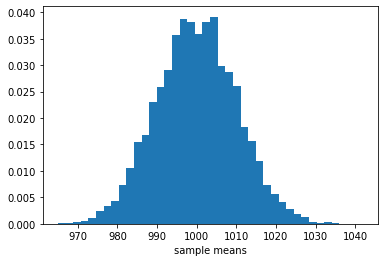

In [ ]:
# The distribution of means follow normal distribution - Central Limit Theorem
plt.hist(sample_avg, histtype='stepfilled', density=True, bins=40)
plt.xlabel("sample means")
plt.show()

This implies that out of all the N sample means in this distribution, 95% of them are within 2 standard deviations from the mean.

So, if we sample multiple times from any true population , compute the sample mean, and create a confidence interval for 95% confidence around it each time, then 95% of times that interval will contain the true population mean.

If the computed mean from a sample is beyond 2 standard deviation from the true population mean, then computing a confidence interval around that sample mean wouldn't contain the true population mean.

### Computing confidence intervals

$ CI = \mu \pm 1.96 S.E $

$S.E = \frac{\sigma}{\sqrt n}$

$\mu $ - sample mean

n - sample size

$\sigma$ - sample standard deviation 

S.E - Standard Error

It indicates how far from the true paramater is our value of the parameter estimated from sampling.

### Example 2



We flipped a coin 100 times resulting in 44H and 56 T

so, P(h) = 0.44

$ X_i$ ~ Bernoulli(p) 

$\sum_i^n X$ ~ B(n, p) 

By CLT, the sample characteristic (here p i.e P(H)) follows a normal distribution after drawing enough samples from the population

i.e P(H) ~ N(p, p(1-p))              



In [ ]:
# considering the above event as one of the samples of size 100 drawn from the true Binomial distribution, 
# sum of X_i
num_samples = 1                                      # 1 Binomial event with 100 bernoulli trials
n_trials = 100
p = 0.44
sample_mean = p*n_trials                             # Expectation of Binomial distribution will be the mean of Normal distribution acc. to CLT
sample_std = np.sqrt(n_trials*p*(1-p))               # Std of Binomial distribution  will be the std of normal distribution by CLT
standard_error = sample_std/np.sqrt(num_samples)

(sample_mean - 1.96*standard_error, sample_mean + 1.96*standard_error)

(34.27081586154317, 53.72918413845683)

In [ ]:
sample_mean, sample_std

(44.0, 4.963869458396343)

In [ ]:
# Using builtin method to compute intervals as alpha % confidence to verify 
CI = stats.norm.interval(alpha=0.95, loc=sample_mean, scale=standard_error) 
CI

(34.27099463758482, 53.72900536241518)

The above is a CI for Binomial distribution with mean n_trials * p.
The CI for Bernoulli distribution with parameter p can be obtained by dividing the above value by n_trials
CI for probability of heads for Bernoulli trial - 


In [ ]:
CI[0]/n_trials, CI[1]/n_trials

(0.34270994637584823, 0.5372900536241518)

In [ ]:
# Using builtin function to derive confidence interval for p in Binomial distribution

proportion.proportion_confint(count=44, nobs=100, alpha=0.05)

(0.34270994637584823, 0.5372900536241518)

In [ ]:
stats.binom.interval(alpha=0.95, n=100, p=0.44, )

(34.0, 54.0)

This is interpreted as the interval which has 95% probability of containing the true value of parameter being estimated (here probability of heads) i.e
when we sample from the true population multiple times and generate confidence intervals for the estimation of probability of heads, 95% of the confidence intervals will contain the true value of this probability.

Frequentist confidence intervals represent the range within which the **interval** has the probability of containing the true value of the parameter i.e an uncertainty associated with the interval, whereas bayesian approach's credible intervals represent the range within which the **true value** of the parameter is most likely to lie i.e an uncertainty associated with the parameter being estimated.

### Example 3

In [ ]:
true_value = 100
sigma = 10
sample_size = 3

np.random.seed(1)

samples = np.random.normal(true_value, sigma, size=3)

In [ ]:
samples

array([116.24345364,  93.88243586,  94.71828248])

In [ ]:
sample_mean, sample_std = samples.mean(), samples.std()
sample_mean, sample_std

(101.61472399249904, 10.34970074096631)

In [ ]:
# standard error of mean calculated from population std and size of samples
sem = sigma * sample_size ** -0.5

sample_mean - 1.96*sem , sample_mean + 1.96*sem

(90.29865871638238, 112.9307892686157)

In [ ]:
# Verifying the above with builtin function

stats.norm.interval(alpha=0.95, loc=sample_mean, scale=sem )

(90.29886665173731, 112.93058133326076)

### Posterior interval estimates by credible regions

Credible interval - single parameter

Credible region - multivariate distributions

$ P(a \le \theta \le b | x) = 1 - \alpha $

$\int_a^b P(\theta|x)d\theta = 1 - \alpha $

1. Equal tailed interval
2. Highest Posterior density 

Equal tailed intervals can be obtained when the posterior distribution is symmetric. The parameter has equal probability in each tail. Can be computed using quantile method.

$P(\theta|x < a ) = 1 - \frac{\alpha}{2}$

$P(\theta|x > b) = 1 - \frac{\alpha}{2}$

Highest Posterior density Interval is the shortest interval with highest probability density and is useful when the posterior density is not symmetric.
There can be multiple intervals satisfying the confidence level, so here HPD chooses the narrowest of these intervals.

### Example


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


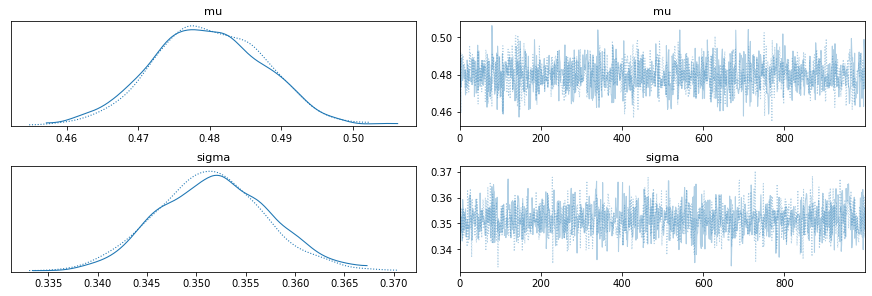

In [ ]:
obs = np.random.normal(loc=0.5, scale=0.35, size=2000)

with pm.Model() as model:
  std = pm.HalfNormal('sigma',sd=0.05)   
  mu = pm.Normal('mu',mu=0.0, sd=0.05)

  likelihood = pm.Normal('y',mu=mu, sd=std, observed=obs)

  trace = pm.sample(1000)            # Uses NUTS sampler by default, based on Hamiltonian Monte Carlo

  pm.traceplot(trace, ['mu', 'sigma'])
  plt.show()

In [ ]:
az.hdi(trace, hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Dimensions without coordinates: hdi
Data variables:
    mu       (hdi) float64 0.485 0.5147
    sigma    (hdi) float64 0.3379 0.359

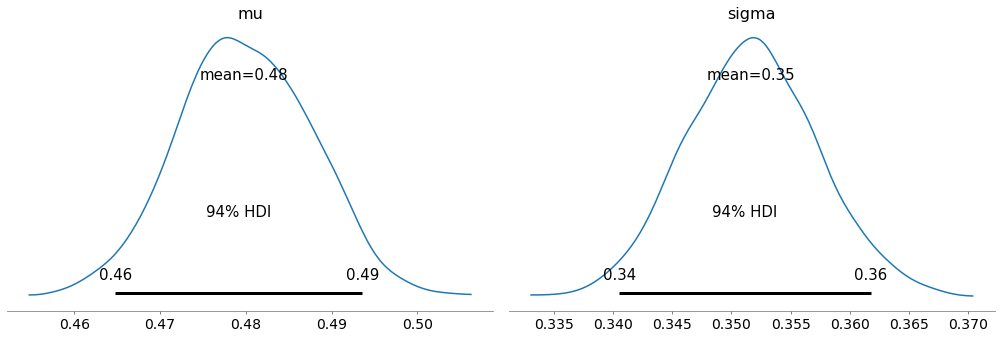

In [ ]:
pm.plot_posterior(trace)
plt.show()

The above posterior distributions are symmetric. Hence, their credible intervals can be obtained by Equal tailed interval or Highest Density Interval with identical results.

In [ ]:
trace['mu'].mean(), trace['sigma'].mean()

(0.4798247975740867, 0.3516320283595251)

In [ ]:
# Equal tailed Credible intervals computed from quantiles

np.percentile(trace['mu'], 2.5), np.percentile(trace['mu'], 97.5)

(0.4642970208374656, 0.49523882694955024)

In [ ]:
# Highest Posterior Density interval
pymc3.stats.hpd(trace['mu']), pymc3.stats.hpd(trace['sigma'])

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


(array([0.46479511, 0.49358209]), array([0.34054003, 0.36175926]))

In [ ]:
np.percentile(trace['sigma'], 2.5), np.percentile(trace['sigma'], 97.5)

(0.34078438348044127, 0.36309985816157603)

In [ ]:
# Generating an asymmetric distribution

np_test_array = stats.expon.rvs(size=1000, scale=10)

(array([459., 241., 122.,  73.,  65.,  20.,   9.,   7.,   1.,   3.]),
 array([5.08599993e-03, 6.07234526e+00, 1.21396045e+01, 1.82068638e+01,
        2.42741230e+01, 3.03413823e+01, 3.64086416e+01, 4.24759008e+01,
        4.85431601e+01, 5.46104194e+01, 6.06776786e+01]),
 <a list of 10 Patch objects>)

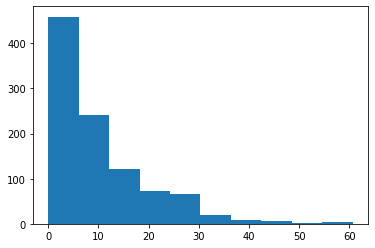

In [ ]:
plt.hist(np_test_array)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb147b5748>],
      dtype=object)

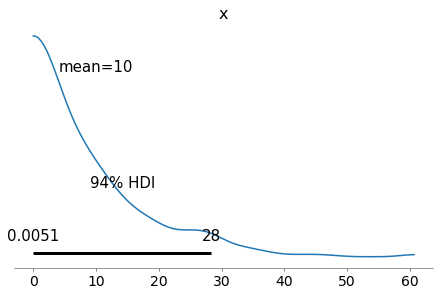

In [ ]:
pm.plot_posterior(np_test_array)

In [ ]:
# Finding credible interval from quantile

np.percentile(np_test_array, 2.5), np.percentile(np_test_array, 97.5)

(0.2976782981645411, 34.030278698541835)

In [ ]:
# Computing credible intervals using highest posterior density 
pymc3.stats.hpd(np_test_array)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


array([5.08599993e-03, 2.83526865e+01])

In the above case with asymmetric distribution, the credible intervals obtained from equal tailed technique are different from that obtained from HDI.

### References
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6386284/
* http://www2.stat.duke.edu/~rcs46/lecturesModernBayes/601-module3-morebayes/lecture5-more-bayes.pdf
* https://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/#:~:text=When%20trying%20to%20estimate%20the,a%20credible%20region%20(CR).